<a href="https://colab.research.google.com/github/koltaib/Melanoma_Detection/blob/main/MelanomaDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is a melanoma detection notebook.

**Prevent disconnecting**

Set a javascript interval to click on the connect button every 60 seconds. Open developer-settings (in your web-browser) with Ctrl+Shift+I then click on console tab and type this on the console prompt. (for mac press Option+Command+I)

```
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
```




In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Bea

root_path = '/content/drive/My Drive/Deep learning a gyakorlatban'

In [ ]:
# Adrienn

root_path = '/content/drive/My Drive/DL/Deep learning a gyakorlatban'

In [ ]:
# Viktor

root_path = '/content/drive/MyDrive/Egyetem/Deep learning a gyakorlatban'

In [ ]:
# Set False if you just want to see the results.
# Set True if you want to make changes in the project.
developer = False

In [ ]:
# Local variables

# Path for metadata
metadata = root_path + '/original_files/HAM10000_metadata.csv'

# Datasets
train_ds = root_path + '/data/new_datasets/train'
test_ds = root_path + '/data/new_datasets/test'
valid_ds = root_path + '/data/new_datasets/validation'

# Checkpoint for effnet
checkpoints_effnet = root_path + '/checkpoints/effnet/' + 'bestcheckpoint_{epoch:02d}_{val_loss:.3f}_{val_accuracy:.3f}.hdf5'
best_weights_effnet = root_path + '/checkpoints/effnet/'

# Checkpoint for inception
checkpoints_inception = root_path + '/checkpoints/inception/' + 'bestcheckpoint_{epoch:02d}_{val_loss:.3f}_{val_accuracy:.3f}.hdf5'
best_weights_inception = root_path + '/checkpoints/inception/'

In [ ]:
# Import necessary libs

import pandas as pd
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import cv2
import gc
from google.colab.patches import cv2_imshow

In [ ]:
# Read csv file to metadata dataframe

metadata = pd.read_csv(metadata)
print(metadata.shape)
metadata.head(10)

(10015, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [ ]:
# Select melanoma records in metadata

melanoma_data = metadata.loc[metadata['dx'] == 'mel']

print(melanoma_data.shape)
melanoma_data.head(3)

(1113, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
1211,HAM_0000871,ISIC_0025964,mel,histo,40.0,female,chest
1212,HAM_0000871,ISIC_0030623,mel,histo,40.0,female,chest
1213,HAM_0000040,ISIC_0027190,mel,histo,80.0,male,upper extremity


In [ ]:
# Find and delete duplicated images
if developer:
    
  sum = 0
  dir = ''
  for filename in tqdm(os.listdir(dir)):
      if (filename.find("(")) != -1:
          os.remove(dir + "/" + filename)
          sum += 1
  sum

In [ ]:
# Count melanoma datas in metadata

sum = 0
for ind in metadata.index:  
     if metadata['dx'][ind] == 'mel':
         sum = sum + 1
print(sum)

1113


In [ ]:
# Separate melanoma jpg files from other
if developer:
    
  for filename in os.listdir(others_images_path):
      id = os.path.splitext(filename)[0]
      for i in melanoma_data.index:
          if melanoma_data['image_id'][i] == id:
              shutil.move(others_images_path + '/' + filename, melanoma_images_path)


In [ ]:
# Count jpg files in directory
if developer:

  dir = ''
  sum = 0
  for filename in os.listdir(dir):
    if filename.endswith(".jpg"): 
        sum = sum + 1
  print(sum)

3564


In [ ]:
# Count melanoma jpg files in directory
if developer:

  dir = ''
  sum = 0
  for filename in os.listdir(dir):
      id = os.path.splitext(filename)[0]
      for i in melanoma_data.index:
          if melanoma_data['image_id'][i] == id:
              sum = sum + 1
  print(sum)

In [ ]:
# Create balanced datasets with data augmentation
if developer:

  # To generate names for the images
  def formatter(prefix, suffix):
    if suffix < 1000:
      prefix = prefix + '0'
    if suffix < 100:
      prefix = prefix + '0'
    if suffix < 10:
      prefix = prefix + '0'
    return prefix + str(suffix) + ".jpg"

  # Melanoma images
  dir = root_path + '/data/images/melanoma'
  dst = root_path + '/data/new_images/melanoma/'
  index = 0
  for filename in tqdm(os.listdir(dir)):
    src = dir + "/" + filename
    if index < 111:
       shutil.copy(src, dst + formatter("melanoma_", index))
    elif index < 222:
       shutil.copy(src, dst + formatter("melanoma_", index))
    else:
      # Rotate images
       img = cv2.imread(src)
       img_horizontal = cv2.flip(img, 0)
       img_vertical = cv2.flip(img, 1)
       img_horizontal_vertical = cv2.flip(img, -1)
       # Save images
       cv2.imwrite(dst + formatter("melanoma_", index), img)
       cv2.imwrite(dst + formatter("melanoma_", index+1), img_horizontal)
       cv2.imwrite(dst + formatter("melanoma_", index+2), img_vertical)
       cv2.imwrite(dst + formatter("melanoma_", index+3), img_horizontal_vertical)
       index += 3
    index += 1

  # Others images
  dir = root_path + '/images/others'
  prefix = root_path + '/data/new_images/others/'
  index = 0
  for filename in tqdm(os.listdir(dir)[:3786]):
      src = dir + "/" + filename
      shutil.copy(src, prefix + formatter("others_", index))
      index += 1

100%|██████████| 3786/3786 [20:02<00:00,  3.15it/s]


In [ ]:
# Separate melanoma images
if developer:

  dir = root_path + '/data/new_images/melanoma'
  dst_root = root_path + '/data/new_datasets/'
  index = 0

  for filename in tqdm(os.listdir(dir)):
    src = dir + "/" + filename
    if index < 111:
        shutil.copy(src, dst + "test/melanoma/")
    elif index < 222:
        shutil.copy(src, dst + "validation/melanoma/")
    else:
        shutil.copy(src, dst + "train/melanoma/")
    index += 1

100%|██████████| 3786/3786 [00:44<00:00, 84.43it/s]


In [ ]:
# Separate others images
if developer:
    
  dir = root_path + '/data/new_images/others'
  dst_root = root_path + '/data/new_datasets/'
  index = 0

  for filename in tqdm(os.listdir(dir)):
    src = dir + "/" + filename
    if index < 111:
        shutil.copy(src, dst + "test/others/")
    elif index < 222:
        shutil.copy(src, dst + "validation/others/")
    else:
        shutil.copy(src, dst + "train/others/")
    index += 1

100%|██████████| 3786/3786 [01:01<00:00, 61.43it/s]


In [ ]:
# Check dx attribute

print("dx:")
dx = metadata['dx']
dx.value_counts()

dx:


nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 432x288 with 0 Axes>

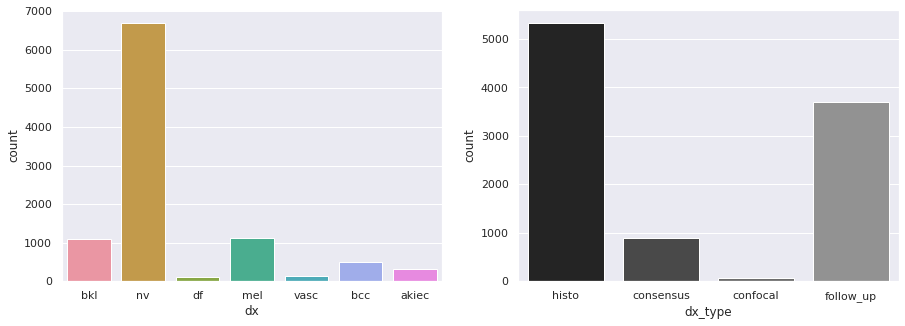

In [ ]:
# Visualize dataset

fig = plt.figure()
sns.set(style='darkgrid', context='notebook', palette='gray')
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(dx, ax=ax[0])
sns.countplot(dx_type, ax=ax[1])

In [ ]:
# Import necessary libs

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Dropout
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

!pip install -U efficientnet
from keras import layers
import efficientnet.keras as efn
from keras import regularizers
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras import applications

Requirement already up-to-date: efficientnet in /usr/local/lib/python3.6/dist-packages (1.1.1)


In [ ]:
# Set 0 if you want to use EfficientNet based model.
# Set 1 if you want to use InceptionV3 based mofel.
model_id = 0

In [ ]:
#-------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------
#------------------------------------------- LOAD DATA -------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------
# Load data in batches with an ImageDataGenerator

datagen_train = ImageDataGenerator(
                    featurewise_center=False, 
                    samplewise_center=False,
                    featurewise_std_normalization=False, 
                    samplewise_std_normalization=False,
                    zca_whitening=False, 
                    rotation_range=40,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    brightness_range=None, 
                    shear_range=0.2,
                    zoom_range=0.2,
                    channel_shift_range=0.0, 
                    fill_mode='nearest', 
                    cval=0.0, 
                    horizontal_flip=False,
                    vertical_flip=False,
                    rescale=1.0/255.0, 
                    preprocessing_function=None,
                    data_format=None, 
                    validation_split=0.0, 
                    dtype=None)

datagen_test = ImageDataGenerator(
                    rescale=1.0/255.0)

# Shape of the images (lxl)
if model_id is 0:
  l = 224
else:
  l = 299

# Iterators for each dataset
train_it = datagen_train.flow_from_directory(train_ds, class_mode='binary', batch_size=16, target_size= (l, l))
val_it = datagen_test.flow_from_directory(valid_ds, class_mode='binary', batch_size=16, target_size= (l, l))
test_it = datagen_test.flow_from_directory(test_ds, class_mode='binary',batch_size=16, target_size=(l, l))

batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 7128 images belonging to 2 classes.
Found 222 images belonging to 2 classes.
Found 222 images belonging to 2 classes.
Batch shape=(16, 299, 299, 3), min=0.000, max=1.000


In [ ]:
# Build the model

if model_id == 0: 
  base_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
else: 
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

model = base_model.output
model = GlobalAveragePooling2D()(model)
model = Dense(128, activation='relu')(model)
predictions = Dense(1, activation='sigmoid')(model)
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze the layers
for layer in model.layers[0:]:
layer.trainable = True

# Set learning rate
if model_id == 0:
  my_lr = 0.0001
else:
  my_lr = 0.00001

optimizer=optimizers.Adam(lr=my_lr)
model.compile(optimizer=optimizer,loss="binary_crossentropy", metrics=['accuracy']) 

In [ ]:
# Visualizing the model 

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Callback functions

# Earlystop
earlystop_callback = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# Save the most accurate model's weights
if model_id == 0: cp = checkpoints_effnet
else: cp = checkpoints_inception
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                          filepath=cp,
                          save_weights_only=True,
                          monitor='val_accuracy',
                          mode='max',
                          save_best_only=True)

# Modify LR during train
lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.000005)

In [ ]:
# Train the model

my_callbacks = [
                earlystop_callback,
                checkpoint_callback,
                # lr_callback
]

h = model.fit(train_it, epochs = 50, validation_data = val_it, callbacks = my_callbacks, shuffle = True, steps_per_epoch = 100)

In [ ]:
# Load the model

if model_id == 0:
  dir = best_weights_effnet
else:
  dir = best_weights_inception

if len(os.listdir(dir)) == 0:
  print("There are no previous checkpoints. Make sure you use the correct directory.")
else:
  filename = os.listdir(dir)[-1]
  best_weight = dir + filename
  print(best_weight)
  model.load_weights(best_weight)

/content/drive/MyDrive/Egyetem/Deep learning a gyakorlatban/checkpoints/effnet/bestcheckpoint_10_0.375_0.847.hdf5


In [ ]:
# Evaluate the model 

results = model.evaluate(test_it, batch_size=16)
print("Test loss: {:.4f}".format(results[0]))
print("Test accuracy: {:.4f}".format(results[1]))

14/14 [==============================] - 3s 183ms/step - loss: 0.3056 - accuracy: 0.8874
Test loss: 0.3056
Test accuracy: 0.8874


Text(0.5, 1.0, 'Loss and Validation Loss')

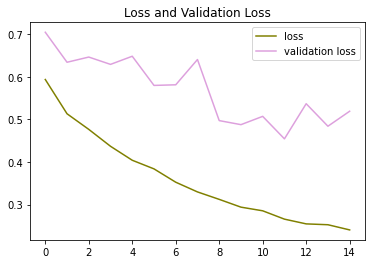

In [ ]:
# Plotting train loss and validation loss

plt.figure()
plt.plot(h.history['loss'],color="olive", label='loss')
plt.plot(h.history['val_loss'], color="plum", label='validation loss')
plt.legend(loc='best')
plt.title(label="Loss and Validation Loss")

Text(0.5, 1.0, 'Accuracy and Validation Accuracy')

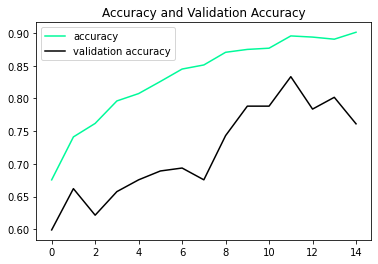

In [ ]:
# Plotting train accuracy and validation accuracy

plt.figure()
plt.plot(h.history['accuracy'],color="mediumspringgreen", label='accuracy')
plt.plot(h.history['val_accuracy'], color="black", label='validation accuracy')
plt.legend(loc='best')
plt.title(label="Accuracy and Validation Accuracy")